# Annual migration of the Emerald Ash Borer

#### Load python tools

In [1]:
%load_ext lab_black

In [2]:
import pandas as pd
import geopandas as gpd
import altair as alt
import us

/Users/stiles/.local/share/virtualenvs/grid-notebooks-Amv9DX-2/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [3]:
pd.options.display.max_columns = 1000
pd.options.display.max_rows = 1000

---

In [4]:
src = pd.read_excel(
    "data/raw/EAB_County_Timeline.xlsx",
    names=["county", "state", "year"],
)

In [5]:
src.head()

,county,state,year
0,Calhoun,Alabama,2016
1,St. Clair,Alabama,2017
2,Talladega,Alabama,2017
3,Ashley,Arkansas,2018
4,Baxter,Arkansas,2018


In [6]:
src["place"] = src["county"] + ", " + src["state"]

In [7]:
name_to_ap = us.states.mapping("name", "ap_abbr")

In [8]:
ap_to_fips = us.states.mapping("ap_abbr", "fips")

In [9]:
src["ap_state"] = src["state"].map(name_to_ap)
src["state_fips"] = src["ap_state"].map(ap_to_fips)

In [10]:
src["decade"] = src["year"].astype(str).str[:3] + "0s"

In [11]:
src["period"] = pd.cut(
    x=src["year"],
    bins=[2001, 2005, 2011, 2016, 2022],
    labels=["2002-05", "2010-14", "2015-19", "2020-22"],
)

In [12]:
src = src.sort_values("year", ascending=True)

In [13]:
df = src.copy()

---

#### Geography

In [14]:
counties = gpd.read_file("data/raw/usa_counties_esri_simple_mainland.json")

In [15]:
counties_slim = counties[
    [
        "name",
        "state_name",
        "cnty_fips",
        "fips",
        "population",
        "geometry",
    ]
].copy()

<AxesSubplot:>

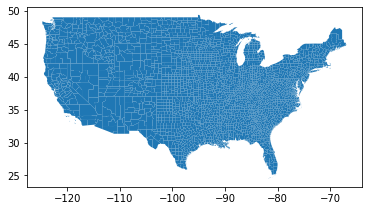

In [16]:
counties_slim.plot()

In [17]:
counties_slim["county_name"] = (
    counties_slim["name"].str.replace(" County", "").str.replace(" Parish", "")
)

In [18]:
counties_slim.head()

,name,state_name,cnty_fips,fips,population,geometry,county_name
0,Autauga County,Alabama,001,01001,58224,"POLYGON ((-86.41312 32.70739, -86.71422 32.705...",Autauga
1,Baldwin County,Alabama,003,01003,227660,"MULTIPOLYGON (((-87.51839 30.28293, -87.55452 ...",Baldwin
2,Barbour County,Alabama,005,01005,26326,"POLYGON ((-85.05603 32.06306, -85.10498 32.062...",Barbour
3,Bibb County,Alabama,007,01007,23066,"POLYGON ((-87.06574 33.24691, -87.10411 33.221...",Bibb
4,Blount County,Alabama,009,01009,59970,"POLYGON ((-86.45302 34.25932, -86.51938 34.252...",Blount


---

## Merge

In [19]:
counties_merged = pd.merge(
    counties_slim,
    df,
    left_on=["state_name", "county_name"],
    right_on=["state", "county"],
    how="right",
)

In [20]:
len(counties_merged)

1301

<AxesSubplot:>

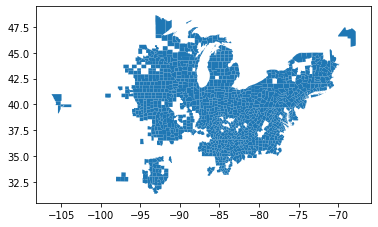

In [21]:
counties_merged.plot()

---

## Show progression

In [22]:
counties_merged.columns

Index(['name', 'state_name', 'cnty_fips', 'fips', 'population', 'geometry',
       'county_name', 'county', 'state', 'year', 'place', 'ap_state',
       'state_fips', 'decade', 'period'],
      dtype='object')

In [23]:
counties_merged.head()

,name,state_name,cnty_fips,fips,population,geometry,county_name,county,state,year,place,ap_state,state_fips,decade,period
0,Wayne County,Michigan,163,26163,1782235.0,"MULTIPOLYGON (((-83.12541 42.12917, -83.13694 ...",Wayne,Wayne,Michigan,2002,"Wayne, Michigan",Mich.,26,2000s,2002-05
1,Monroe County,Michigan,115,26115,155620.0,"MULTIPOLYGON (((-83.45538 41.73285, -83.45356 ...",Monroe,Monroe,Michigan,2002,"Monroe, Michigan",Mich.,26,2000s,2002-05
2,Washtenaw County,Michigan,161,26161,370787.0,"POLYGON ((-83.53940 42.08561, -83.55191 42.435...",Washtenaw,Washtenaw,Michigan,2002,"Washtenaw, Michigan",Mich.,26,2000s,2002-05
3,Livingston County,Michigan,093,26093,195702.0,"POLYGON ((-83.66481 42.43119, -83.68650 42.783...",Livingston,Livingston,Michigan,2002,"Livingston, Michigan",Mich.,26,2000s,2002-05
4,Oakland County,Michigan,125,26125,1254738.0,"POLYGON ((-83.08340 42.44716, -83.10290 42.888...",Oakland,Oakland,Michigan,2002,"Oakland, Michigan",Mich.,26,2000s,2002-05


In [24]:
gdf = counties_merged[
    ["county", "ap_state", "fips", "year", "decade", "period", "geometry"]
].copy()

In [25]:
gdf = gdf.sort_values("year")

2002-05
2010-14
2015-19
2020-22


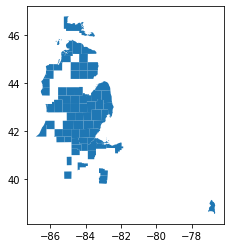

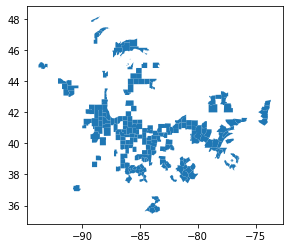

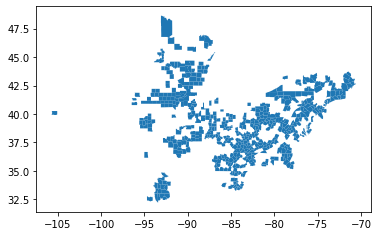

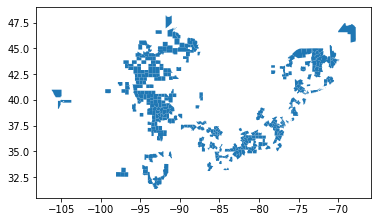

In [26]:
for period in gdf.period.unique():
    print(period)
    gdf[gdf["period"] == period].plot()

---

## Export

In [27]:
gdf["period"] = gdf["period"].astype(str)

In [28]:
gdf.to_file("data/processed/borer_progression.geojson", driver="GeoJSON")

In [30]:
gdf[["county", "ap_state", "fips", "year", "decade", "period"]].to_csv(
    "data/processed/borer_progression.csv", index=False
)